# 2020-01-02 • Trying out a full network simulation

In [1]:
from voltage_to_wiring_sim.support.notebook_init import *
vtws = v;  # using 'v' for voltage below

Preloading:
 - numpy … (0.11 s)
 - matplotlib.pyplot … (0.22 s)
 - numba … (0.30 s)

Importing from submodules … ✔

Imported `np`, `mpl`, `plt`
Imported codebase (`voltage_to_wiring_sim`) as `v`
Imported `*` from `v.support.units`
Setup autoreload


## Params

izhikevich parameters for cortical regular spiking neurons

In [2]:
C = 100 * pF
k = 0.7 * (nS/mV)
b = -2 * nS
v_r    = -60 * mV
v_t    = -40 * mV
v_peak =  35 * mV
v_syn  =   0 * mV
c      = -50 * mV
a = 0.03 / ms
d = 100 * pA;

In [6]:
connection_strengths = np.array([
    [0, 1, 0],
    [0, 0, 0.8],
    [1, 0, 0],
]) * 12 * nS  # [from, to]

τ_syn = 7 * ms;

In [7]:
dt = 0.1 * ms
sim_duration = 0.3 * second;

In [8]:
spike_delay = (4 + 0.5) * ms;  # axonal conduction + synaptic delay

[Scholarpedia on axonal conduction delay](http://www.scholarpedia.org/article/Axonal_conduction_delays)

Initial synaptic conductances

In [9]:
g_0 = np.array([10, 0, 0]) * nS;

## Sim

In [10]:
def to_num_timesteps(time):
    return round(time / dt)

num_sim_timesteps = to_num_timesteps(sim_duration)
spike_delay_timesteps = to_num_timesteps(spike_delay)

45

In [11]:
num_neurons = connection_strengths.shape[0];

signals_shape = (num_sim_timesteps, num_neurons)

v = np.zeros(signals_shape)
u = np.zeros(signals_shape)
g = np.zeros(signals_shape)  # g_syn
I = np.zeros(signals_shape);  # I_syn

In [12]:
spikes = [[] for _ in range(num_neurons)]
num_processed_spikes = [0 for _ in range(num_neurons)]

dg_dt = lambda t,n: -g[t,n] / τ_syn
dv_dt = lambda t,n: (k * (v[t,n] - v_r) * (v[t,n] - v_t) - u[t,n] - I[t,n]) / C
du_dt = lambda t,n: a * (b * (v[t,n] - v_r) - u[t,n])

for t in range(num_sim_timesteps):
    
    for n in range(num_neurons):
        
        if t == 0:
            g[t, n] = g_0[n]
            v[t, n] = v_r
            u[t, n] = 0
        else:
            g[t, n] += g[t-1, n] + dt * dg_dt(t-1, n)
            if (num_processed_spikes[n] < len(spikes[n])
              and spikes[n][num_processed_spikes[n]] + spike_delay_timesteps == t):
                for m in range(num_neurons):
                    g[t, m] += connection_strengths[n, m]
                num_processed_spikes[n] += 1
            
            v[t, n] = v[t-1, n] + dt * dv_dt(t-1, n)
            u[t, n] = u[t-1, n] + dt * du_dt(t-1, n)
            if v[t, n] >= v_peak:
                v[t-1, n] = v_peak
                v[t, n] = c
                u[t, n] += d
                spikes[n].append(t)                    
            I[t, n] = g[t, n] * (v[t, n] - v_syn)

## Output

In [13]:
spikes

[[203, 880, 1656, 2441], [400, 1096, 1871, 2655], [658, 1436, 2222]]

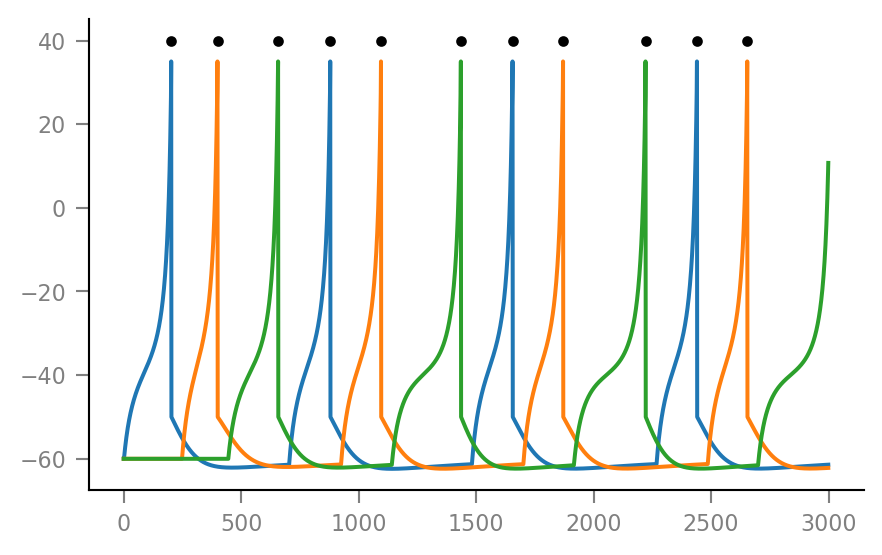

In [14]:
for n in range(num_neurons):
    plt.plot(v[:,n] / mV)
    for s in spikes[n]:
        plt.plot(s, 40, 'k.')

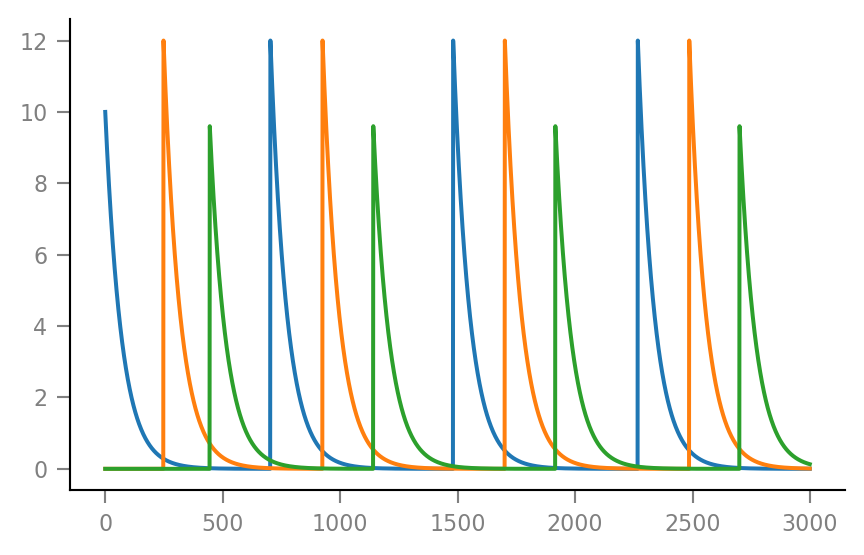

In [15]:
for n in range(num_neurons):
    plt.plot(g[:,n] / nS)

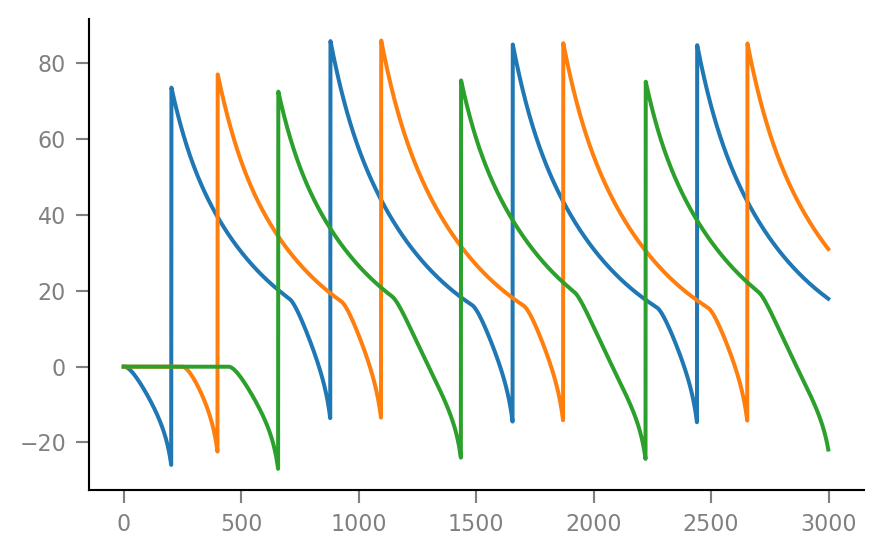

In [16]:
for n in range(num_neurons):
    plt.plot(u[:,n] / pA)

## Reproducibility

In [17]:
vtws.print_reproducibility_info(verbose=True)

This cell was last run by `tfiers` on `yoga`<br>on **Sat 02 Jan** 2021, at 21:47 (UTC+0100).

[Last git commit](https://github.com/tfiers/voltage-to-wiring-sim/tree/74b36937fd9c3b469c0d66f9f29c44e99928f6ce
) (Sat 02 Jan 2021, 21:38).

Uncommited changes to:
```
 M notebooks/2021_01_02__full_network_sim_tryout.ipynb
```

Platform:

Windows-10
CPython 3.8.3 (C:\conda\python.exe)
Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz


Dependencies of `voltage_to_wiring_sim` and their installed versions:

numpy                1.19.2
matplotlib           3.3.2
numba                0.51.2
seaborn              0.10.1
scipy                1.5.2
scikit-learn         0.23.2
preload              2.1
py-cpuinfo           7.0.0
nptyping             1.3.0
tqdm                 4.55.0
